# ML-Enhanced Pairs Trading Strategy

This notebook implements a pairs trading strategy using:
- Classical statistical arbitrage ideas (Gatev et al., 2006)
- Sarmento & Horta (2020): Enhancing a Pairs Trading Strategy with the Application of Machine Learning

The goal is to identify economically similar stocks, test for long-run
relationships, and prepare the ground for mean-reversion trading.


In [34]:
# Core
import numpy as np
import pandas as pd

# Data
import yfinance as yf

# Statistics & ML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint, adfuller
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Modeling
!pip install pykalman
from pykalman import KalmanFilter
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
plt.style.use("seaborn-v0_8")

In [35]:
nifty_df = pd.read_csv("ind_nifty100list.csv")

In [36]:

# If column name is Symbol (most likely)
symbols = nifty_df["Symbol"].astype(str).str.strip()

tickers = (symbols + ".NS").tolist()

len(tickers), tickers[:10]

# Remove obvious junk symbols
tickers = [t for t in tickers if t not in ["NIFTYBEES.NS", "BANKBEES.NS"]]

print("Final universe size:", len(tickers))

Final universe size: 99


In [37]:
START_DATE = "2019-01-01"
END_DATE   = "2025-01-01"

prices = yf.download(
    tickers,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)["Close"]


# Drop assets with too many missing values
prices = prices.dropna(axis=1, how="any")

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TMPV.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1546281000, endDate = 1735669800")')


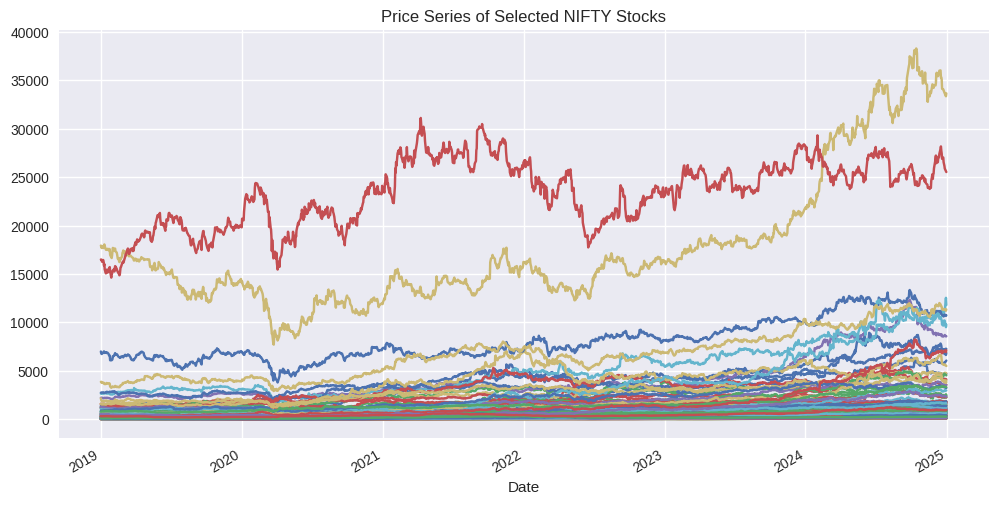

In [38]:
prices.plot(figsize=(12, 6), legend=False)
plt.title("Price Series of Selected NIFTY Stocks")
plt.show()

In [39]:
split_date = "2022-01-01"  # ~50/50 split

formation_prices = prices[prices.index < split_date].copy()
trading_prices = prices[prices.index >= split_date].copy()

# Further split formation into training + validation (70/30)
formation_split_idx = int(len(formation_prices) * 0.7)
train_prices = formation_prices.iloc[:formation_split_idx].copy()
validation_prices = formation_prices.iloc[formation_split_idx:].copy()

print("DATA SPLIT")
print(f"Training:   {train_prices.index[0]} to {train_prices.index[-1]} ({len(train_prices)} days)")
print(f"Validation: {validation_prices.index[0]} to {validation_prices.index[-1]} ({len(validation_prices)} days)")
print(f"Trading:    {trading_prices.index[0]} to {trading_prices.index[-1]} ({len(trading_prices)} days)")

DATA SPLIT
Training:   2019-01-01 00:00:00 to 2021-02-05 00:00:00 (519 days)
Validation: 2021-02-08 00:00:00 to 2021-12-31 00:00:00 (223 days)
Trading:    2022-01-03 00:00:00 to 2024-12-31 00:00:00 (739 days)


### PCA + OPTICS (Unsupervised Pair Selection)

PCA is first applied to standardized asset returns to capture the dominant latent market factors and reduce noise.  
OPTICS is then used on the reduced feature space to cluster assets with similar return dynamics, constraining the pair search space to statistically comparable instruments.


In [40]:
# Log returns
train_returns = np.log(train_prices / train_prices.shift(1)).dropna()

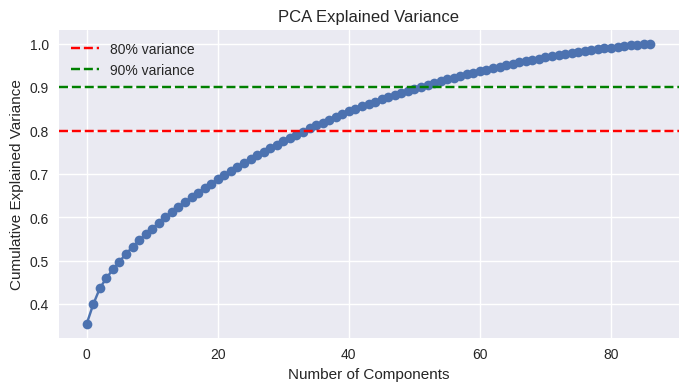

In [41]:
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(train_returns)

returns_scaled.shape
pca = PCA()
pca.fit(returns_scaled)
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(explained_var, marker="o")
plt.axhline(0.80, linestyle="--", color="red", label="80% variance")
plt.axhline(0.90, linestyle="--", color="green", label="90% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.legend()
plt.show()


In [42]:
# Choose components explaining ~85% variance
n_components = np.argmax(explained_var >= 0.85) + 1
n_components


np.int64(43)

In [43]:
# 1. Transpose FIRST: each row = stock
returns_scaled_T = returns_scaled.T   # shape: (n_stocks, n_time)

print("returns_scaled_T:", returns_scaled_T.shape)

# 2. PCA on STOCKS
pca = PCA(n_components=n_components)
X_cluster = pca.fit_transform(returns_scaled_T)

print("X_cluster:", X_cluster.shape)

# 3. OPTICS clustering (stocks)
optics = OPTICS(
    min_samples=2,
    xi=0.05,
    min_cluster_size=2
)

cluster_labels = optics.fit_predict(X_cluster)

print("cluster_labels:", len(cluster_labels))

stock_names = train_returns.columns
print("stock_names:", len(stock_names))

cluster_df = pd.DataFrame({
    "Stock": stock_names,
    "Cluster": cluster_labels
})



returns_scaled_T: (87, 518)
X_cluster: (87, 43)
cluster_labels: 87
stock_names: 87


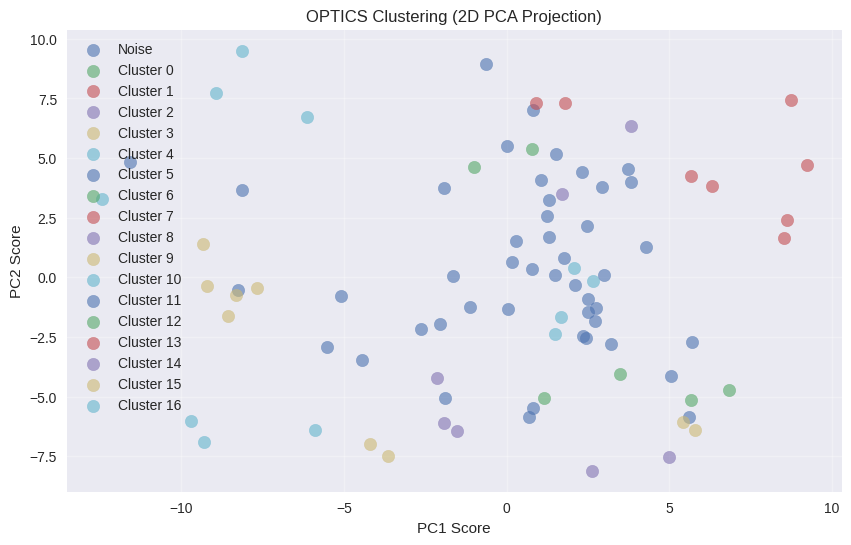

In [44]:
plt.figure(figsize=(10, 6))

for cluster in np.unique(cluster_labels):
    mask = cluster_labels == cluster
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"

    plt.scatter(
        X_cluster[mask, 0],
        X_cluster[mask, 1],
        label=label,
        s=80, alpha = 0.6
    )

plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.title("OPTICS Clustering (2D PCA Projection)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [45]:
from itertools import combinations

# Create cluster-wise stock groups (exclude noise = -1)
clusters = (
    cluster_df[cluster_df["Cluster"] != -1]
    .groupby("Cluster")["Stock"]
    .apply(list)
)

clusters


,Stock
Cluster,
0,"[AXISBANK.NS, ICICIBANK.NS]"
1,"[BANKBARODA.NS, CANBK.NS, PNB.NS, SBIN.NS]"
2,"[HDFCBANK.NS, KOTAKBANK.NS]"
3,"[BAJAJFINSV.NS, BAJFINANCE.NS]"
4,"[AMBUJACEM.NS, GRASIM.NS, SHREECEM.NS, ULTRACE..."
5,"[HINDALCO.NS, JINDALSTEL.NS, JSWSTEEL.NS, TATA..."
6,"[EICHERMOT.NS, MARUTI.NS]"
7,"[PFC.NS, RECLTD.NS]"
8,"[HDFCLIFE.NS, ICICIGI.NS, SBILIFE.NS]"


In [46]:
candidate_pairs = []

for cluster_stocks in clusters:
    if len(cluster_stocks) >= 2:
        candidate_pairs.extend(list(combinations(cluster_stocks, 2)))

len(candidate_pairs), candidate_pairs


(54,
 [('AXISBANK.NS', 'ICICIBANK.NS'),
  ('BANKBARODA.NS', 'CANBK.NS'),
  ('BANKBARODA.NS', 'PNB.NS'),
  ('BANKBARODA.NS', 'SBIN.NS'),
  ('CANBK.NS', 'PNB.NS'),
  ('CANBK.NS', 'SBIN.NS'),
  ('PNB.NS', 'SBIN.NS'),
  ('HDFCBANK.NS', 'KOTAKBANK.NS'),
  ('BAJAJFINSV.NS', 'BAJFINANCE.NS'),
  ('AMBUJACEM.NS', 'GRASIM.NS'),
  ('AMBUJACEM.NS', 'SHREECEM.NS'),
  ('AMBUJACEM.NS', 'ULTRACEMCO.NS'),
  ('GRASIM.NS', 'SHREECEM.NS'),
  ('GRASIM.NS', 'ULTRACEMCO.NS'),
  ('SHREECEM.NS', 'ULTRACEMCO.NS'),
  ('HINDALCO.NS', 'JINDALSTEL.NS'),
  ('HINDALCO.NS', 'JSWSTEEL.NS'),
  ('HINDALCO.NS', 'TATASTEEL.NS'),
  ('HINDALCO.NS', 'VEDL.NS'),
  ('JINDALSTEL.NS', 'JSWSTEEL.NS'),
  ('JINDALSTEL.NS', 'TATASTEEL.NS'),
  ('JINDALSTEL.NS', 'VEDL.NS'),
  ('JSWSTEEL.NS', 'TATASTEEL.NS'),
  ('JSWSTEEL.NS', 'VEDL.NS'),
  ('TATASTEEL.NS', 'VEDL.NS'),
  ('EICHERMOT.NS', 'MARUTI.NS'),
  ('PFC.NS', 'RECLTD.NS'),
  ('HDFCLIFE.NS', 'ICICIGI.NS'),
  ('HDFCLIFE.NS', 'SBILIFE.NS'),
  ('ICICIGI.NS', 'SBILIFE.NS'),
  ('ASIANPAI

### Cointegration

An Engle–Granger cointegration test is applied to candidate pairs to verify the existence of a mean-reverting spread.


In [47]:
from statsmodels.tsa.stattools import coint

cointegrated_pairs = []

for cluster_id, cluster_stocks in clusters.items():
    if len(cluster_stocks) < 2:
        continue

    for s1, s2 in combinations(cluster_stocks, 2):
      try:
        score, pvalue, _ = coint(train_prices[s1], train_prices[s2])

        if pvalue < 0.05:
            cointegrated_pairs.append({
                "Cluster": cluster_id,
                "Stock1": s1,
                "Stock2": s2,
                "Coint_pvalue": pvalue
            })
      except:
        continue

cointegrated_df = pd.DataFrame(cointegrated_pairs)
cointegrated_df.sort_values("Coint_pvalue")

cointegrated_df


,Cluster,Stock1,Stock2,Coint_pvalue
0,1,BANKBARODA.NS,CANBK.NS,0.005134
1,8,HDFCLIFE.NS,ICICIGI.NS,0.008259
2,10,HINDUNILVR.NS,NESTLEIND.NS,0.000815
3,13,COALINDIA.NS,ONGC.NS,0.006192
4,15,HCLTECH.NS,INFY.NS,0.019614
5,15,HCLTECH.NS,TCS.NS,0.030186
6,15,INFY.NS,TCS.NS,0.008308


### OLS Hedge Ratio

OLS regression estimates the linear relationship between paired assets, producing a static hedge ratio for spread construction.



Estimated hedge ratios for 7 pairs

Top 5 pairs by cointegration strength:
          Stock1        Stock2  Beta_OLS  Spread_Std
2  HINDUNILVR.NS  NESTLEIND.NS  1.153115    0.122146
0  BANKBARODA.NS      CANBK.NS  1.258642    0.175394
3   COALINDIA.NS       ONGC.NS  1.063934    0.106813
1    HDFCLIFE.NS    ICICIGI.NS  0.884731    0.090523
6        INFY.NS        TCS.NS  0.865802    0.099848


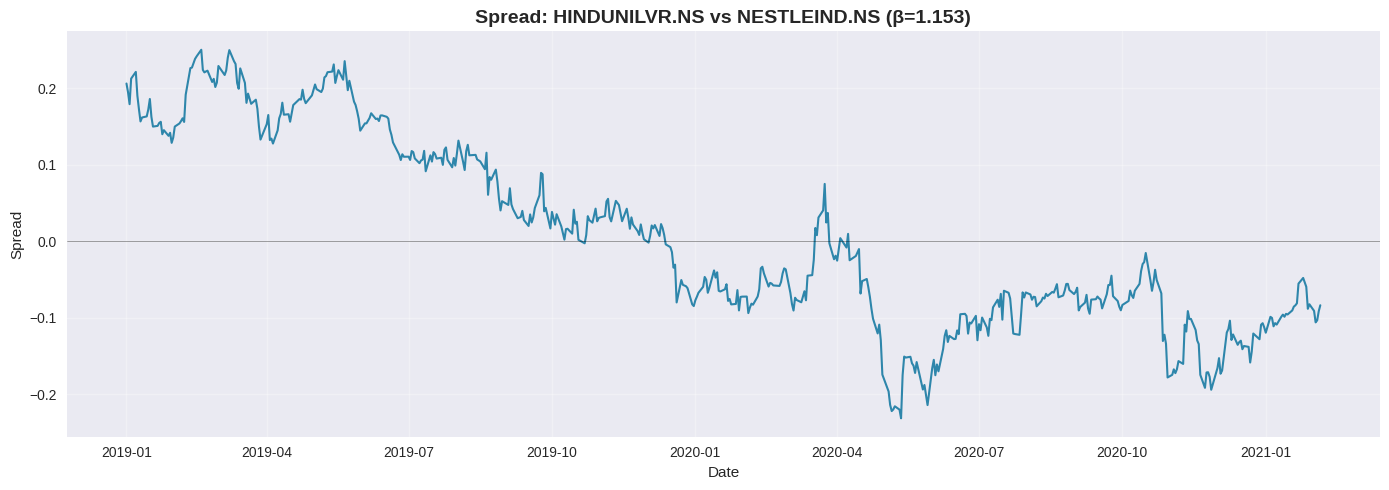


Best pair: HINDUNILVR.NS-NESTLEIND.NS
  Hedge ratio (β): 1.1531
  Spread volatility: 0.122146


In [48]:
hedge_ratios = {}
spread_stats = []

for _, pair in cointegrated_df.iterrows():
    stock1 = pair["Stock1"]
    stock2 = pair["Stock2"]

    # Use training data only
    y_train = np.log(train_prices[stock1])
    x_train = np.log(train_prices[stock2])

    data = pd.concat([y_train, x_train], axis=1).dropna()
    y_train = data.iloc[:, 0]
    x_train = data.iloc[:, 1]

    # OLS hedge ratio (no intercept)
    ols_model = sm.OLS(y_train, x_train).fit()
    beta_ols = ols_model.params.iloc[0]
    spread_ols = y_train - beta_ols * x_train

    # Store hedge ratio
    hedge_ratios[(stock1, stock2)] = beta_ols

    # Calculate statistics
    spread_stats.append({
        "Stock1": stock1,
        "Stock2": stock2,
        "Beta_OLS": beta_ols,
        "Spread_Std": spread_ols.std(),
        "Coint_pvalue": pair["Coint_pvalue"]
    })

spread_stats_df = pd.DataFrame(spread_stats)
print(f"\nEstimated hedge ratios for {len(hedge_ratios)} pairs")
print("\nTop 5 pairs by cointegration strength:")
print(spread_stats_df.nsmallest(5, 'Coint_pvalue')[
    ['Stock1', 'Stock2', 'Beta_OLS', 'Spread_Std']
])

# Simple visualization for best pair
best_pair = spread_stats_df.nsmallest(1, 'Coint_pvalue').iloc[0]
stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']

y_train = np.log(train_prices[stock1])
x_train = np.log(train_prices[stock2])
data = pd.concat([y_train, x_train], axis=1).dropna()
y_train, x_train = data.iloc[:, 0], data.iloc[:, 1]

beta_ols = hedge_ratios[(stock1, stock2)]
spread_ols = y_train - beta_ols * x_train

plt.figure(figsize=(14, 5))
plt.plot(spread_ols.index, spread_ols, linewidth=1.5, color='#2E86AB')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
plt.title(f'Spread: {stock1} vs {stock2} (β={beta_ols:.3f})',
          fontsize=14, fontweight='bold')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest pair: {stock1}-{stock2}")
print(f"  Hedge ratio (β): {beta_ols:.4f}")
print(f"  Spread volatility: {spread_ols.std():.6f}")

### Validation

Selected pairs are validated using statistical diagnostics to ensure robustness and tradability. This includes stationarity checks on the constructed spread, inspection of z-score behavior, and rejection of pairs exhibiting unstable or non-mean-reverting dynamics before backtesting.


In [49]:
def validate_pair_performance(stock1, stock2, beta, val_prices, lookback=80):
    """Calculate performance metrics on validation period"""
    try:
        y = np.log(val_prices[stock1])
        x = np.log(val_prices[stock2])

        data = pd.concat([y, x], axis=1).dropna()
        if len(data) < lookback + 20:
            return None

        y = data.iloc[:, 0]
        x = data.iloc[:, 1]

        # Calculate spread using trained beta
        spread = y - beta * x

        # Calculate z-scores
        mean = spread.rolling(lookback).mean()
        std = spread.rolling(lookback).std()
        zscore = ((spread - mean) / std).dropna()

        if len(zscore) < 20:
            return None

        # Simulate simple trading
        position = 0
        positions = []
        for z in zscore:
            if position == 0 and z < -2:
                position = 1
            elif position == 0 and z > 2:
                position = -1
            elif position != 0 and abs(z) < 0.5:
                position = 0
            elif position != 0 and abs(z) > 3:
                position = 0
            positions.append(position)

        positions = pd.Series(positions, index=zscore.index)
        pnl = positions.shift(1) * spread.loc[zscore.index].diff()
        pnl = pnl.fillna(0)

        # Calculate metrics
        sharpe = (pnl.mean() / pnl.std() * np.sqrt(252)) if pnl.std() > 0 else 0
        total_return = pnl.sum()
        num_trades = (positions.diff().abs() > 0).sum()

        return {
            'sharpe': sharpe,
            'total_return': total_return,
            'num_trades': num_trades
        }
    except:
        return None

In [50]:
# Evaluate all pairs on validation data
print("\nValidating pairs on validation period...")
validation_results = []

for _, pair in cointegrated_df.iterrows():
    stock1 = pair["Stock1"]
    stock2 = pair["Stock2"]
    beta = hedge_ratios[(stock1, stock2)]

    metrics = validate_pair_performance(stock1, stock2, beta, validation_prices)

    if metrics is not None:
        validation_results.append({
            'Stock1': stock1,
            'Stock2': stock2,
            'Beta': beta,
            'Val_Sharpe': metrics['sharpe'],
            'Val_Return': metrics['total_return'],
            'Val_Trades': metrics['num_trades'],
            'Coint_pvalue': pair['Coint_pvalue']
        })

validation_df = pd.DataFrame(validation_results)



Validating pairs on validation period...


In [51]:
# SELECT TOP PAIRS based on validation Sharpe ratio
TOP_N_PAIRS = min(10, len(validation_df))  # Select best N pairs
selected_pairs = validation_df.nlargest(TOP_N_PAIRS, 'Val_Sharpe')

print(f"SELECTED TOP {len(selected_pairs)} PAIRS BASED ON VALIDATION PERFORMANCE")
print(selected_pairs[['Stock1', 'Stock2', 'Val_Sharpe', 'Val_Return', 'Val_Trades']].to_string())

SELECTED TOP 7 PAIRS BASED ON VALIDATION PERFORMANCE
          Stock1        Stock2  Val_Sharpe  Val_Return  Val_Trades
1    HDFCLIFE.NS    ICICIGI.NS    2.043489    0.120608           6
3   COALINDIA.NS       ONGC.NS    0.223091    0.026123          10
4     HCLTECH.NS       INFY.NS    0.182818    0.017431           4
0  BANKBARODA.NS      CANBK.NS   -0.072529   -0.011330           5
5     HCLTECH.NS        TCS.NS   -0.181810   -0.017297           7
2  HINDUNILVR.NS  NESTLEIND.NS   -0.538578   -0.041512           3
6        INFY.NS        TCS.NS   -1.085619   -0.044889           4


In [52]:
# Update cointegrated_df to only include selected pairs
cointegrated_df = cointegrated_df[
    cointegrated_df.apply(
        lambda row: any((row['Stock1'] == sp1 and row['Stock2'] == sp2)
                       for sp1, sp2 in zip(selected_pairs['Stock1'], selected_pairs['Stock2'])),
        axis=1
    )
].copy()

### ARMA Model Fitting

The spread is modeled using an ARMA process to account for serial dependence and to forecast near-term spread movements, aiding in the identification of non-reverting regimes.


In [53]:
def fit_arma_model(spread):
    """Fit ARMA with proper date handling to avoid warnings"""
    if not isinstance(spread, pd.Series):
        spread = pd.Series(spread)

    spread = spread.dropna()

    if len(spread) < 50:
        return None

    # CRITICAL FIX: Reset to integer index to avoid date warnings
    spread_no_dates = pd.Series(spread.values, index=range(len(spread)))

    # Check stationarity
    from statsmodels.tsa.stattools import adfuller
    adf_result = adfuller(spread_no_dates, autolag='AIC')
    is_stationary = adf_result[1] < 0.05
    d = 0 if is_stationary else 1

    # Try different orders
    orders = [(1,d,1), (2,d,1), (1,d,2), (2,d,2), (3,d,2), (1,d,0), (0,d,1)]

    best_model = None
    best_aic = np.inf

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')

        for p, d_val, q in orders:
            try:
                model = ARIMA(spread_no_dates, order=(p, d_val, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_model = fitted
            except:
                continue

    return best_model


print("\n Fitting ARMA models to training spreads...")
arma_models = {}

for _, pair in cointegrated_df.iterrows():
    stock1 = pair["Stock1"]
    stock2 = pair["Stock2"]
    beta = hedge_ratios[(stock1, stock2)]

    # Calculate training spread
    y_train = np.log(train_prices[stock1])
    x_train = np.log(train_prices[stock2])
    data = pd.concat([y_train, x_train], axis=1).dropna()
    spread_train = data.iloc[:, 0] - beta * data.iloc[:, 1]

    # Fit ARMA model (no date index to avoid warnings)
    model = fit_arma_model(spread_train)
    if model is not None:
        arma_models[(stock1, stock2)] = model
        print(f"   ARMA fitted for {stock1[:10]}-{stock2[:10]}")
    else:
        print(f"   ARMA failed for {stock1[:10]}-{stock2[:10]}")

print(f"\nSuccessfully fitted {len(arma_models)}/{len(cointegrated_df)} ARMA models")


 Fitting ARMA models to training spreads...
   ARMA fitted for BANKBARODA-CANBK.NS
   ARMA fitted for HDFCLIFE.N-ICICIGI.NS
   ARMA fitted for HINDUNILVR-NESTLEIND.
   ARMA fitted for COALINDIA.-ONGC.NS
   ARMA fitted for HCLTECH.NS-INFY.NS
   ARMA fitted for HCLTECH.NS-TCS.NS
   ARMA fitted for INFY.NS-TCS.NS

Successfully fitted 7/7 ARMA models


In [54]:
trading_spreads = {}
trading_zscores = {}
lookback = 80

for _, pair in cointegrated_df.iterrows():
    stock1 = pair["Stock1"]
    stock2 = pair["Stock2"]
    beta = hedge_ratios[(stock1, stock2)]

    # Calculate spread on trading period using trained beta
    try:
        y_trade = np.log(trading_prices[stock1])
        x_trade = np.log(trading_prices[stock2])
        data = pd.concat([y_trade, x_trade], axis=1).dropna()

        if len(data) < lookback + 10:
            continue

        y_trade = data.iloc[:, 0]
        x_trade = data.iloc[:, 1]

        spread = y_trade - beta * x_trade

        # Calculate z-score
        mean = spread.rolling(lookback).mean()
        std = spread.rolling(lookback).std()
        zscore = ((spread - mean) / std).dropna()

        trading_spreads[(stock1, stock2)] = spread
        trading_zscores[(stock1, stock2)] = zscore
    except:
        continue

In [55]:
def predict_spread_arma(model, steps=1):
    """Forecast next steps of spread - fixed to avoid warnings"""
    try:
        # Use get_forecast for cleaner API
        forecast_obj = model.get_forecast(steps=steps)
        forecast = forecast_obj.predicted_mean

        # Return as numpy array
        if hasattr(forecast, 'values'):
            forecast = forecast.values
        return forecast[0] if steps == 1 else forecast
    except Exception as e:
        return None

def forecast_based_trading(spread, zscore, arma_model=None, forecast_horizon=5):
    """
    Trading signals based on spread forecasts

    Logic:
    - If spread extreme AND forecast shows reversion -> Enter
    - If in position AND forecast shows divergence -> Stop loss
    - If in position AND spread reverted -> Take profit
    """
    position = 0
    positions = []

    spread_values = spread.values
    zscore_values = zscore.values

    for i in range(len(zscore)):
        forecast_direction = 0

        # Get forecast if model available
        if arma_model is not None and i < len(spread_values):
            try:
                # Get current spread value
                spread_current = spread_values[i]

                # Generate forecast
                forecast = predict_spread_arma(arma_model, steps=forecast_horizon)

                if forecast is not None:
                    # Calculate mean of forecast
                    forecast_mean = np.mean(forecast) if isinstance(forecast, np.ndarray) else forecast

                    # Direction: positive if spread expected to increase
                    forecast_direction = np.sign(forecast_mean - spread_current)
            except Exception as e:
                forecast_direction = 0

        # Get current z-score
        z = zscore_values[i]

        # Trading logic with forecasts
        if position == 0:
            # Entry: extreme z-score AND forecast supports mean reversion
            if z < -2 and forecast_direction >= 0:
                position = 1  # Long spread
            elif z > 2 and forecast_direction <= 0:
                position = -1  # Short spread
        else:
            # Stop loss: forecast shows continued divergence
            if position == 1 and forecast_direction < -0.5 and z < -3:
                position = 0
            elif position == -1 and forecast_direction > 0.5 and z > 3:
                position = 0
            # Take profit: spread reverted
            elif abs(z) < 0.5:
                position = 0

        positions.append(position)

    return pd.Series(positions, index=zscore.index)

# Generate forecast-based positions
forecast_positions = {}

for pair in trading_zscores.keys():
    spread = trading_spreads[pair]
    zscore = trading_zscores[pair]
    arma_model = arma_models.get(pair, None)

    # Align spread with zscore index
    spread_aligned = spread.loc[zscore.index]

    # Use forecast-based trading if model exists
    if arma_model is not None:
        positions = forecast_based_trading(spread_aligned, zscore, arma_model)
    else:
        # Fallback to simple z-score strategy
        position = 0
        positions = []
        zscore_values = zscore.values
        for z in zscore_values:
            if position != 0 and abs(z) > 3:
                position = 0
            elif position == 0 and z < -2:
                position = 1
            elif position == 0 and z > 2:
                position = -1
            elif position != 0 and abs(z) < 0.5:
                position = 0
            positions.append(position)
        positions = pd.Series(positions, index=zscore.index)

    forecast_positions[pair] = positions

### Transaction Costs & Net PnL Computation

Net PnL is computed from spread changes using lagged positions to avoid look-ahead bias. Transaction costs are explicitly modeled as a fixed percentage per trade leg and applied whenever position changes occur. Net portfolio PnL is obtained by aggregating pair-level PnL after deducting round-trip trading costs.


In [56]:
transaction_cost = 0.001  # 0.1% per leg

# Calculate PnL for forecast-based strategy
pnl_dict = {}
for pair in forecast_positions.keys():
    spread = trading_spreads[pair]
    position = forecast_positions[pair]

    # Align
    common_idx = spread.index.intersection(position.index)
    spread = spread.loc[common_idx]
    position = position.loc[common_idx]

    # PnL
    pnl = position.shift(1) * spread.diff()
    pnl = pnl.fillna(0)

    # Transaction costs
    trades = position.diff().abs().fillna(0)
    costs = 2 * transaction_cost * trades

    # Net PnL
    pnl_dict[pair] = pnl - costs.reindex(pnl.index).fillna(0)

# Portfolio PnL
portfolio_pnl_forecast = pd.concat(pnl_dict.values(), axis=1).sum(axis=1)

print("FORECAST-BASED STRATEGY RESULTS (Trading Period)")
print(f"Period: {portfolio_pnl_forecast.index[0]} to {portfolio_pnl_forecast.index[-1]}")
print(f"Days: {len(portfolio_pnl_forecast)}")
print(f"Pairs: {len(pnl_dict)}")

FORECAST-BASED STRATEGY RESULTS (Trading Period)
Period: 2022-04-29 00:00:00 to 2024-12-31 00:00:00
Days: 660
Pairs: 7


In [57]:
# Generate simple z-score positions
simple_positions = {}

for pair in trading_zscores.keys():
    zscore = trading_zscores[pair]

    position = 0
    positions = []

    for z in zscore:
        if position != 0 and abs(z) > 3:
            position = 0
        elif position == 0 and z < -2:
            position = 1
        elif position == 0 and z > 2:
            position = -1
        elif position != 0 and abs(z) < 0.5:
            position = 0

        positions.append(position)

    simple_positions[pair] = pd.Series(positions, index=zscore.index)

# Calculate PnL for simple strategy
simple_pnl_dict = {}
for pair in simple_positions.keys():
    spread = trading_spreads[pair]
    position = simple_positions[pair]

    common_idx = spread.index.intersection(position.index)
    spread = spread.loc[common_idx]
    position = position.loc[common_idx]

    pnl = position.shift(1) * spread.diff()
    trades = position.diff().abs().fillna(0)
    costs = 2 * transaction_cost * trades

    simple_pnl_dict[pair] = (pnl - costs.reindex(pnl.index).fillna(0)).fillna(0)

portfolio_pnl_simple = pd.concat(simple_pnl_dict.values(), axis=1).sum(axis=1)

### Performance Evaluation & Strategy Comparison

Performance metrics are computed on portfolio-level PnL, including annualized return, volatility, Sharpe ratio, maximum drawdown, and drawdown duration. The forecast-based strategy is directly compared against the baseline z-score strategy to quantify improvements in risk-adjusted returns and drawdown characteristics.


In [58]:
def performance_metrics(pnl, freq=252):
    """Calculate performance metrics"""
    mean_ret = pnl.mean() * freq
    vol = pnl.std() * np.sqrt(freq)
    sharpe = mean_ret / vol if vol != 0 else np.nan

    cum = pnl.cumsum()
    running_max = cum.cummax()
    drawdown = cum - running_max
    max_dd = drawdown.min()

    # Drawdown duration
    dd_duration = 0
    current_dd_days = 0
    max_dd_days = 0
    for dd in drawdown:
        if dd < 0:
            current_dd_days += 1
            max_dd_days = max(max_dd_days, current_dd_days)
        else:
            current_dd_days = 0

    return {
        "Annualized Return": mean_ret,
        "Annualized Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Max DD Duration (days)": max_dd_days
    }

forecast_metrics = performance_metrics(portfolio_pnl_forecast)
simple_metrics = performance_metrics(portfolio_pnl_simple)

comparison = pd.DataFrame({
    'Forecast-Based': forecast_metrics,
    'Simple Z-Score': simple_metrics
})

print("STRATEGY COMPARISON (Trading Period)")
print(comparison)

# Calculate improvements
sharpe_improvement = ((forecast_metrics['Sharpe Ratio'] / simple_metrics['Sharpe Ratio']) - 1) * 100
dd_reduction = (1 - abs(forecast_metrics['Max Drawdown']) / abs(simple_metrics['Max Drawdown'])) * 100
dd_duration_reduction = (1 - forecast_metrics['Max DD Duration (days)'] / simple_metrics['Max DD Duration (days)']) * 100

print(f"\nImprovements from Forecasting:")
print(f"  Sharpe Ratio: {sharpe_improvement:+.1f}%")
print(f"  Max Drawdown: {dd_reduction:+.1f}% reduction")
print(f"  DD Duration: {dd_duration_reduction:+.1f}% reduction")
print(f"\n  Paper claims: 75% reduction in decline periods")

STRATEGY COMPARISON (Trading Period)
                        Forecast-Based  Simple Z-Score
Annualized Return             0.017779       -0.081212
Annualized Volatility         0.396736        0.452422
Sharpe Ratio                  0.044813       -0.179506
Max Drawdown                 -0.745287       -1.021962
Max DD Duration (days)      439.000000      467.000000

Improvements from Forecasting:
  Sharpe Ratio: -125.0%
  Max Drawdown: +27.1% reduction
  DD Duration: +6.0% reduction

  Paper claims: 75% reduction in decline periods


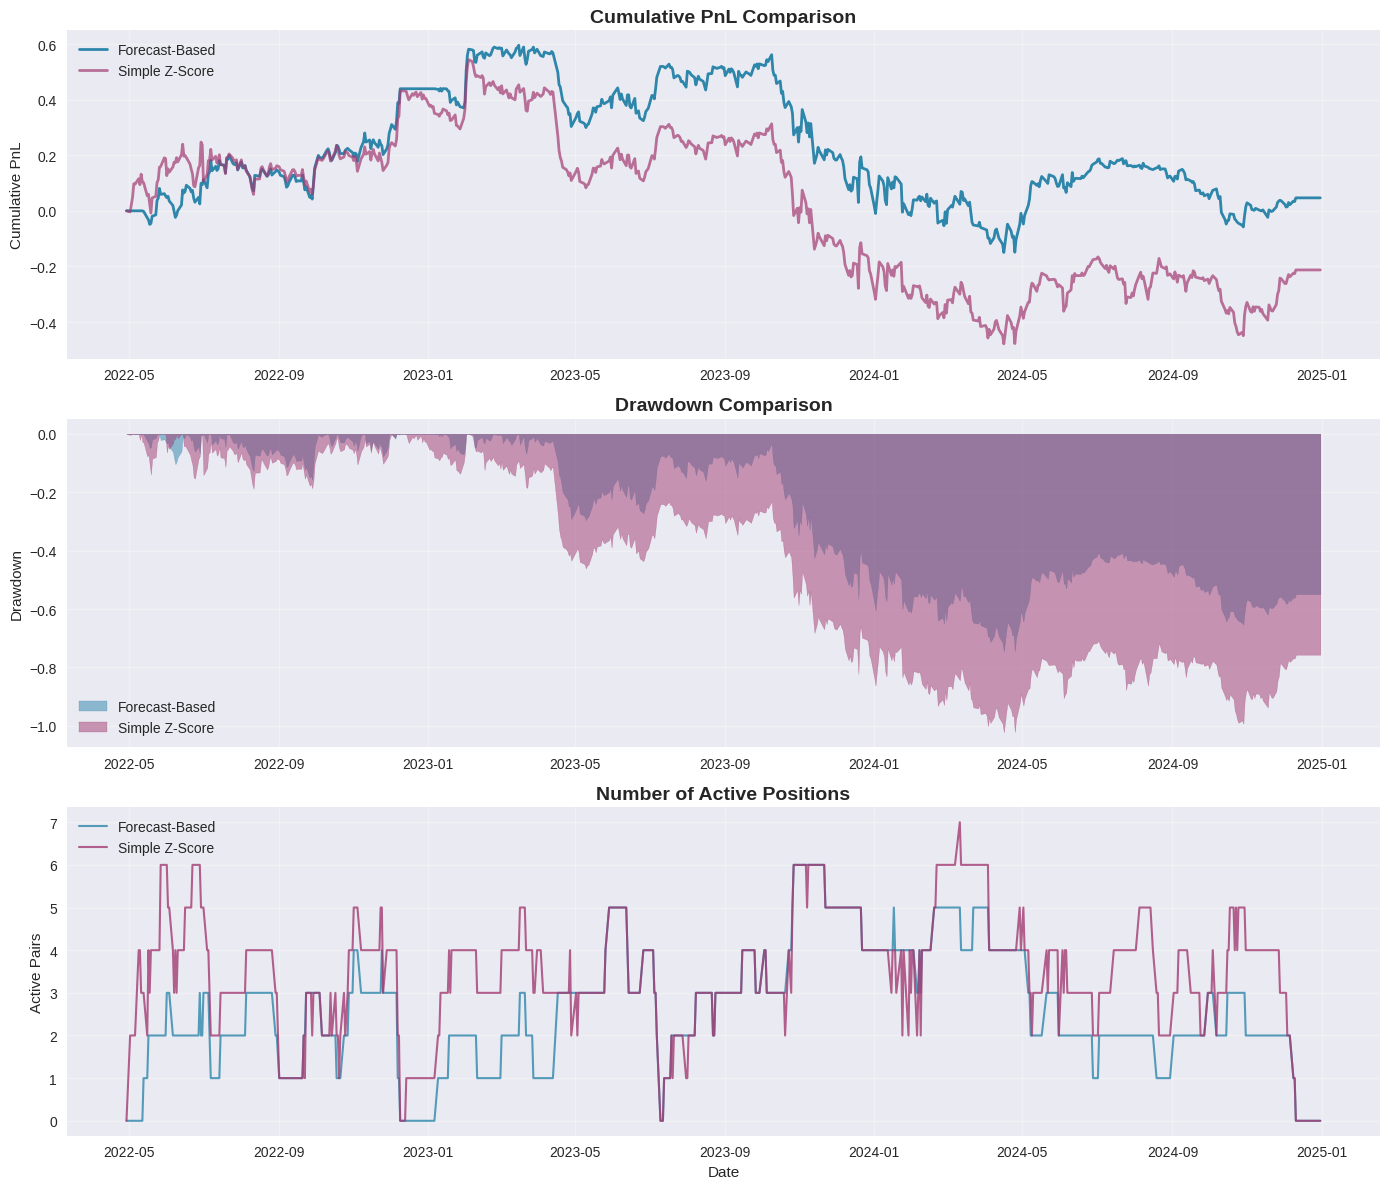

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Cumulative PnL
ax1 = axes[0]
forecast_cum = portfolio_pnl_forecast.cumsum()
simple_cum = portfolio_pnl_simple.cumsum()
ax1.plot(forecast_cum, label='Forecast-Based', linewidth=2, color='#2E86AB')
ax1.plot(simple_cum, label='Simple Z-Score', linewidth=2, alpha=0.7, color='#A23B72')
ax1.set_title('Cumulative PnL Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative PnL')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Drawdowns
ax2 = axes[1]
forecast_dd = forecast_cum - forecast_cum.cummax()
simple_dd = simple_cum - simple_cum.cummax()
ax2.fill_between(forecast_dd.index, 0, forecast_dd, alpha=0.5,
                 label='Forecast-Based', color='#2E86AB')
ax2.fill_between(simple_dd.index, 0, simple_dd, alpha=0.5,
                 label='Simple Z-Score', color='#A23B72')
ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Number of active positions
ax3 = axes[2]
forecast_active = pd.concat(forecast_positions.values(), axis=1).abs().sum(axis=1)
simple_active = pd.concat(simple_positions.values(), axis=1).abs().sum(axis=1)
ax3.plot(forecast_active, label='Forecast-Based', linewidth=1.5, alpha=0.8, color='#2E86AB')
ax3.plot(simple_active, label='Simple Z-Score', linewidth=1.5, alpha=0.8, color='#A23B72')
ax3.set_title('Number of Active Positions', fontsize=14, fontweight='bold')
ax3.set_ylabel('Active Pairs')
ax3.set_xlabel('Date')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
print("TRADE STATISTICS")

# Total trades
forecast_trades = sum((forecast_positions[p].diff().abs() > 0).sum() for p in forecast_positions)
simple_trades = sum((simple_positions[p].diff().abs() > 0).sum() for p in simple_positions)

print(f"\nTotal Trades:")
print(f"  Forecast-based: {forecast_trades}")
print(f"  Simple Z-score: {simple_trades}")
print(f"  Difference: {forecast_trades - simple_trades} ({(forecast_trades/simple_trades - 1)*100:+.1f}%)")

# Win rate
def calculate_win_rate(pnl_dict):
    all_trades = []
    for pnl in pnl_dict.values():
        trades = pnl[pnl != 0]
        all_trades.extend(trades.values)
    wins = sum(1 for t in all_trades if t > 0)
    total = len(all_trades)
    return wins / total if total > 0 else 0

forecast_wr = calculate_win_rate(pnl_dict)
simple_wr = calculate_win_rate(simple_pnl_dict)

print(f"\nWin Rate:")
print(f"  Forecast-based: {forecast_wr:.2%}")
print(f"  Simple Z-score: {simple_wr:.2%}")

TRADE STATISTICS

Total Trades:
  Forecast-based: 88
  Simple Z-score: 210
  Difference: -122 (-58.1%)

Win Rate:
  Forecast-based: 49.52%
  Simple Z-score: 48.38%
